c:\Users\kavin\Desktop\car-insurance-claim-Final\car-insurance-claim-Final\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:12:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Logistic Regression Report:
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88      1373
         1.0       0.74      0.72      0.73       627

    accuracy                           0.83      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.83      0.83      0.83      2000


Decision Tree Report:
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82      1373
         1.0       0.61      0.62      0.62       627

    accuracy                           0.76      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.76      0.76      0.76      2000


Random Forest Report:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      1373
         1.0       0.72      0.65      0.68       627

    accuracy                           0.81      2000
   macro avg       0.78      0.77      0.77      2000

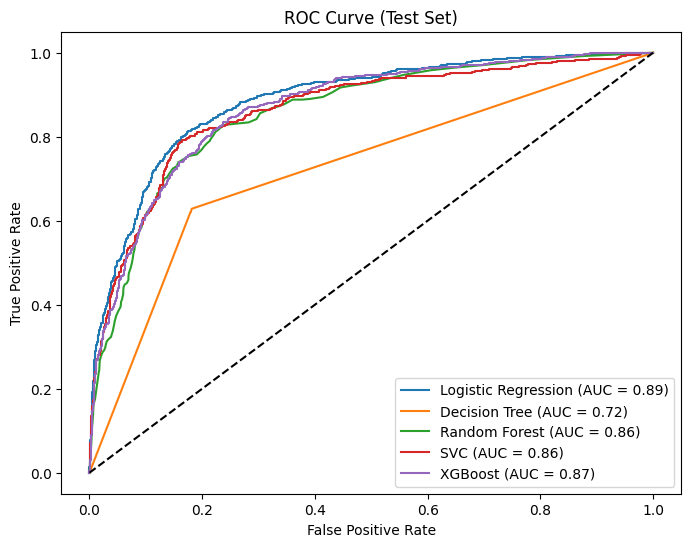

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib
import os

# Load data
df = pd.read_csv('../data/processed/preprocessed_data.csv')
X = df.drop('OUTCOME', axis=1)
y = df['OUTCOME']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Load preprocessor (if used in your pipeline, ensure consistency)
preprocessor = joblib.load('../models/preprocessor.pkl')

# Train models
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

svc_model = SVC(probability=True, random_state=42)
svc_model.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Store models
models = {
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'SVC': svc_model,
    'XGBoost': xgb_model
}

# Predictions and probabilities on TEST set
predictions = {}
probabilities = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test)
    probabilities[name] = model.predict_proba(X_test)[:, 1]

# Classification reports
for name, pred in predictions.items():
    print(f"\n{name} Report:")
    print(classification_report(y_test, pred))

# Metrics table
metrics_data = []
for name, pred in predictions.items():
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, probabilities[name])
    metrics_data.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': auc
    })

metrics_df = pd.DataFrame(metrics_data)
print("\nMetrics Table:")
print(metrics_df.to_string(index=False))

# ROC Curve
os.makedirs('../outputs/figures', exist_ok=True)
plt.figure(figsize=(8, 6))
for name, proba in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.savefig('../outputs/figures/roc_curve.png')
plt.show()
plt.close()
